<a href="https://colab.research.google.com/github/nardenelbanna/final-project/blob/main/Copy_of_CNN__midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile # Import the zipfile module
import os      # Import the os module
import json
import cv2  #Accessing the file
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input, Lambda
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

In [ ]:
#Unzip the dataset
zip_path = '/content/drive/MyDrive/Colab Notebooks/train.zip'
extract_to = '/content/cancer'

zip_path_test = '/content/drive/MyDrive/Colab Notebooks/breast_cancer_dataset.zip'
extract_test_to = '/content/test_cancer'

with zipfile.ZipFile(zip_path, 'r') as zip_ref: #[1]
    zip_ref.extractall(extract_to)

with zipfile.ZipFile(zip_path_test, 'r') as zip_ref: #[1]
    zip_ref.extractall(extract_test_to)
#Confirm contents
print(f"Contents of {extract_to}: {os.listdir(extract_to)}")
print(f"Contents of {extract_test_to}: {os.listdir(extract_test_to)}")

Contents of /content/cancer: ['__MACOSX', 'train']
Contents of /content/test_cancer: ['breast_cancer_dataset', '__MACOSX']


In [ ]:
# Setting the paths
base_dir = '/content/cancer/train'
img_dir = os.path.join(base_dir, 'img') #[2]
ann_dir = os.path.join(base_dir, 'ann')

dataset = []

# Loop through annotation files [2]
for filename in os.listdir(ann_dir): #[2]
    if filename.endswith('.json'): #[3]
        ann_path = os.path.join(ann_dir, filename)

        # Read JSON annotation file
        with open(ann_path, 'r') as f:
            data = json.load(f)

        # Extract labels from tags
        tags = [tag['name'].lower() for tag in data.get('tags', [])]

        # Assign label: 0 = benign, 1 = malignant
        if 'malignant' in tags:
            label = 1
        elif 'benign' in tags:
            label = 0
        elif 'benign_without_callback' in tags:
            label = 0
        else:
            continue  # Skip if label not found

        # Get corresponding image path and remove .json
        image_filename = filename.replace('.json', '')
        image_path = os.path.join(img_dir, image_filename)

        # Checking image file exists
        if os.path.isfile(image_path): #[2]
            dataset.append((image_path, label))

print(f"Total samples: {len(dataset)}")
print(dataset[:3])

Total samples: 2456
[('/content/cancer/train/img/Calc-Training_P_00639_RIGHT_MLO_FULL_PRE.png', 1), ('/content/cancer/train/img/Mass-Training_P_00900_LEFT_MLO_FULL_PRE.png', 1), ('/content/cancer/train/img/Mass-Training_P_01207_RIGHT_MLO_FULL_PRE.png', 0)]


In [ ]:
labels = [label for _, label in dataset]
print(f"Total benign samples: {labels.count(0)}")

Total benign samples: 1354


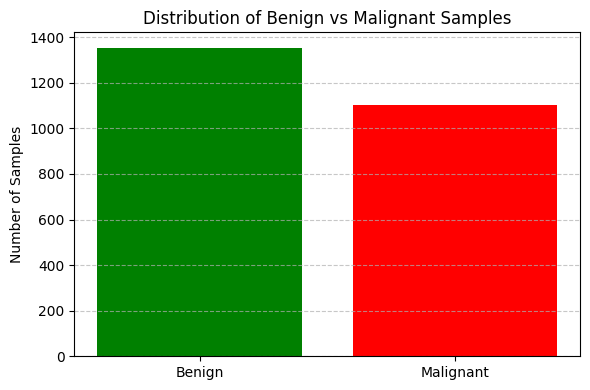

In [ ]:
labels = list(map(lambda x: x[1], dataset))
benign_count = labels.count(0)
malignant_count = labels.count(1)

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(['Benign', 'Malignant'], [benign_count, malignant_count], color=['green', 'red'])
plt.title('Distribution of Benign vs Malignant Samples')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#Checking image size
sizes = set()

In [ ]:
# Show a few images to verify labels
def show_image_label_pairs(dataset, num_samples=5):

    for i in range(min(num_samples, len(dataset))):
        img_path, label = dataset[i]

        # Read image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #[4]
        img = cv2.resize(img, (224, 224)) #[5]
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        #slices only the first 2 values W,H
        height, width = img.shape[:2]
        sizes.add((width, height))  # (W, H)
        # Image with label title
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {'Malignant' if label == 1 else 'Benign'}\nFile: {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()



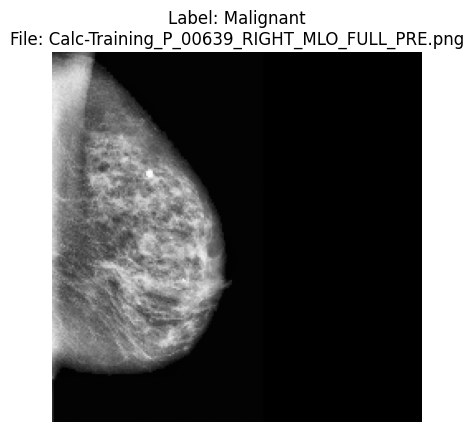

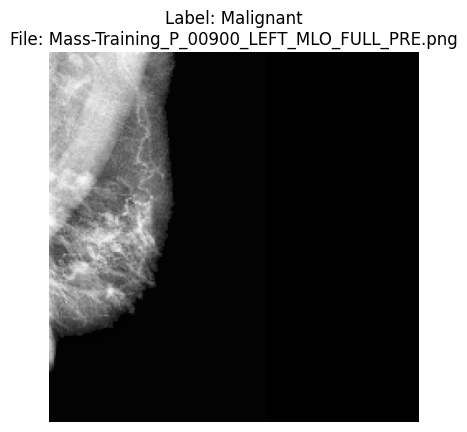

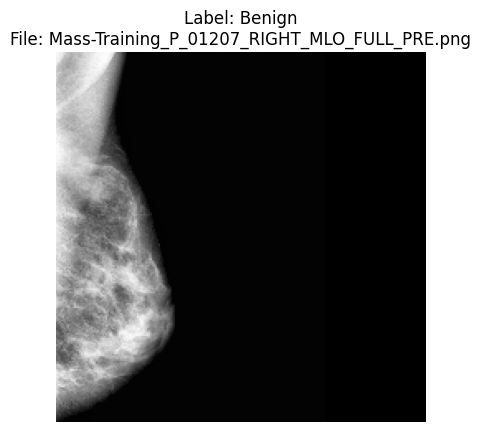

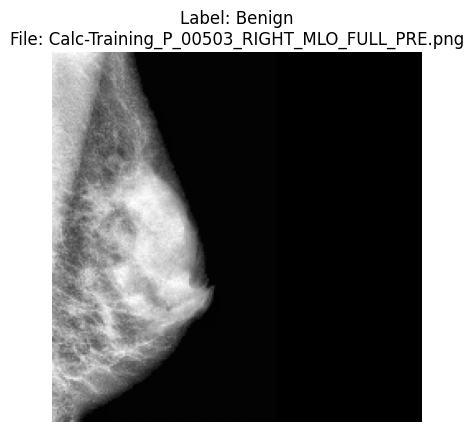

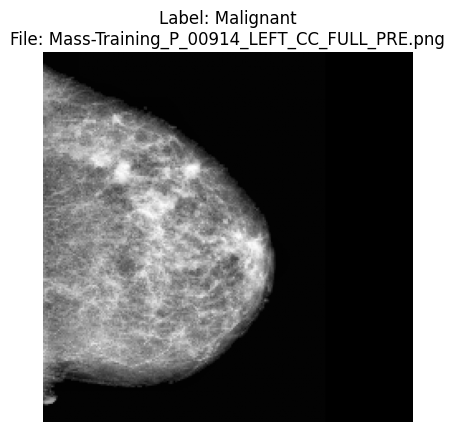

In [ ]:
# Show 5 random samples
show_image_label_pairs(dataset, num_samples=5)

In [ ]:
#Print results
print(f"Unique image sizes: {sizes}")
if len(sizes) == 1:
  print("All images are the same size.")
else:
  print("Images have different sizes.")

Unique image sizes: {(224, 224)}
All images are the same size.


In [ ]:
# Setting the paths for the testing dataset
base_dir_test = '/content/test_cancer/breast_cancer_dataset/test'
img_dir_test = os.path.join(base_dir_test, 'img') #[2]
ann_dir_test = os.path.join(base_dir_test, 'ann') #[2]

test_dataset = []

# Loop through annotation files
for test_file in os.listdir(ann_dir_test): #[2]
    if test_file.endswith('.json'): #[3]
        ann_path_test = os.path.join(ann_dir_test, test_file)

        # Read JSON annotation file
        with open(ann_path_test, 'r') as f:
            test_data = json.load(f)

        # Extract labels from tags
        tags = [tag['name'].lower() for tag in test_data.get('tags', [])]

        # Assign label: 0 = benign, 1 = malignant
        if 'malignant' in tags:
            label = 1
        elif 'benign' in tags:
            label = 0
        elif 'benign_without_callback' in tags:
            label = 0
        else:
            continue  # Skip if label is not found

        # Get corresponding image path and remove .json
        image_test_file = test_file.replace('.json', '')
        image_path_test = os.path.join(img_dir_test, image_test_file)

        # Checking image file exists
        if os.path.isfile(image_path_test):
            test_dataset.append((image_path_test, label))

print(f"Total samples: {len(test_dataset)}")
print(test_dataset[:3])

Total samples: 645
[('/content/test_cancer/breast_cancer_dataset/test/img/Calc-Test_P_01272_LEFT_MLO_FULL_PRE.png', 0), ('/content/test_cancer/breast_cancer_dataset/test/img/Mass-Test_P_01333_LEFT_MLO_FULL_PRE.png', 1), ('/content/test_cancer/breast_cancer_dataset/test/img/Mass-Test_P_00156_RIGHT_MLO_FULL_PRE.png', 0)]


In [ ]:
# Shuffle the dataset
random.shuffle(dataset)

# Split into train, val, test
train, val = train_test_split(dataset, test_size=0.20, random_state=42)
test = test_dataset
print(f"Train: {len(train)}, Val: {len(val)}")
print(f"Test: {len(test)}")

Train: 1964, Val: 492
Test: 645


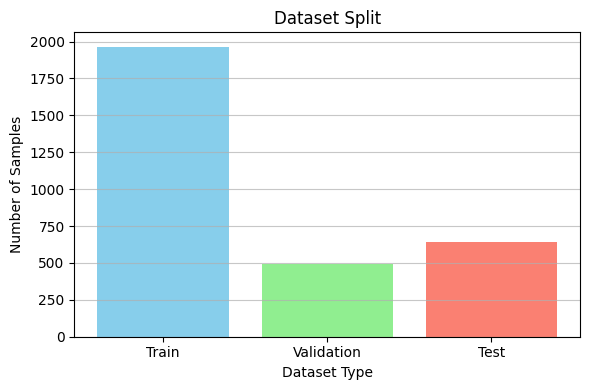

In [ ]:
train_len = len(train)
val_len = len(val)
test_len = len(test)
labels = ['Train', 'Validation', 'Test']
sizes = [train_len, val_len, test_len]

# Create a bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, sizes, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Dataset Split')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset Type')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
def load_dataset(data_list, target_size=(224, 224)):
    X = []
    y = []

    for img_path, label in data_list:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #[5]
        if img is not None:
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) #[7]
            img = img.astype('float32') / 255.0

            X.append(img)
            y.append(label)
#covnverting to numpy arrey
    return np.array(X), np.array(y)

# Load the sets
X_train, y_train = load_dataset(train)
X_val, y_val = load_dataset(val)


print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

Shapes:
X_train: (1964, 224, 224, 3)
y_train: (1964,)


In [ ]:
def load_test_dataset(test_data_list, target_size=(224, 224)):
    X = []
    y = []

    for image_path_test, label in test_data_list:
        img_t = cv2.imread(image_path_test, cv2.IMREAD_GRAYSCALE) #[5]
        if img_t is not None:
            img_t = cv2.resize(img_t, target_size) #[5]
            img_t = cv2.cvtColor(img_t, cv2.COLOR_GRAY2RGB)#[6]
            img_t = img_t.astype('float32') / 255.0

            X.append(img_t)
            y.append(label)

#covnverting to numpy arrey
    return np.array(X), np.array(y)

# Load test dataset
X_test, y_test = load_test_dataset(test)

#Print the results
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_test: (645, 224, 224, 3)
y_test: (645,)


In [ ]:
#balancing the dataset [7]
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: np.float64(0.9117920148560817), 1: np.float64(1.1071025930101466)}


In [ ]:
#data augmentation [8]
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [ ]:
#[9] Convolutional Neural Network
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,

    layers.Conv2D(24, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001)),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.00001)),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(84, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(124, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


In [ ]:
history = model.fit(X_train, y_train, epochs=30, class_weight=class_weights_dict, validation_data=(X_val, y_val), batch_size=64,callbacks=[early_stop])

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.4586 - loss: 0.6939 - precision: 0.4548 - recall: 0.9918 - val_accuracy: 0.4370 - val_loss: 0.6964 - val_precision: 0.4370 - val_recall: 1.0000
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4652 - loss: 0.6942 - precision: 0.4568 - recall: 0.8858 - val_accuracy: 0.4451 - val_loss: 0.6955 - val_precision: 0.4388 - val_recall: 0.9674
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4797 - loss: 0.6952 - precision: 0.4638 - recall: 0.7859 - val_accuracy: 0.4472 - val_loss: 0.6950 - val_precision: 0.4333 - val_recall: 0.8605
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5001 - loss: 0.6927 - precision: 0.4591 - recall: 0.6426 - val_accuracy: 0.5020 - val_loss: 0.6939 - val_precision: 0.4510 - val_recall: 0.6419
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5030 - loss: 0.6925 - precision: 0.4544 - recall: 0.5560 - val_accuracy: 0.5061 - val_loss: 0.6936

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 24)   │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 84)     │        48,468 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 84)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 124)    │        93,868 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 124)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3100)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       793,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,887,685 (11.02 MB)

 Trainable params: 962,561 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,925,124 (7.34 MB)

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

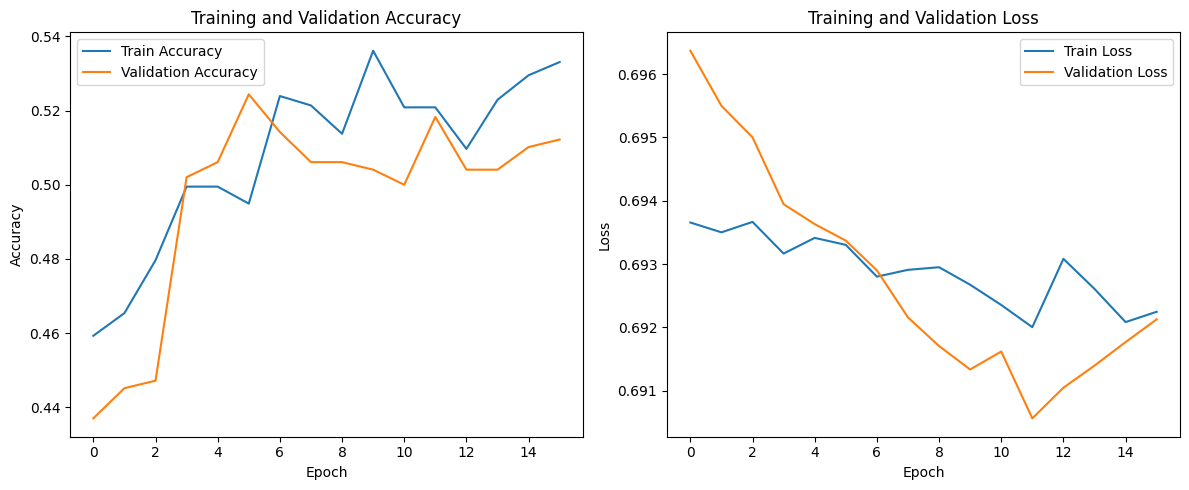

In [ ]:
plot_training_history(history)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


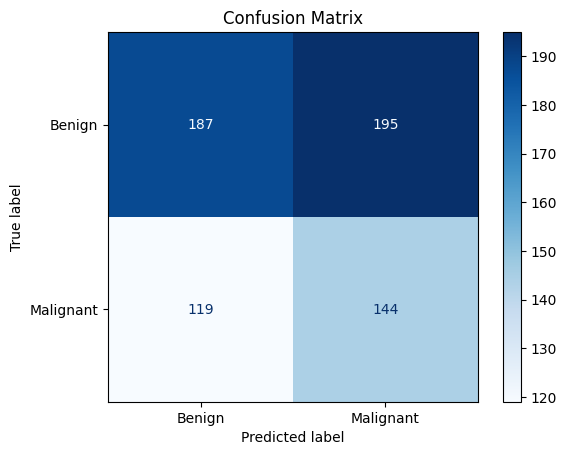

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5065 - loss: 0.6935 - precision: 0.3947 - recall: 0.5119


In [ ]:
print("Train class counts:", np.bincount(y_train))
print("Val class counts:", np.bincount(y_val))

Train class counts: [1077  887]
Val class counts: [277 215]


In [ ]:
#vgg-16 [10]
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in vgg16.layers:
    layer.trainable = False

inputs = Input((224,224,3))
x = data_augmentation(inputs)
#denormlize pixels
x = layers.Lambda(lambda t: t * 255.0)(x)
x = layers.Lambda(preprocess_input)(x)
x = vgg16(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,749,633 (56.27 MB)

 Trainable params: 33,921 (132.50 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg16 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop,reduce_lr]
)


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.4892 - loss: 0.9254 - precision: 0.4628 - recall: 0.7048 - val_accuracy: 0.4370 - val_loss: 1.8223 - val_precision: 0.4370 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4900 - loss: 0.9185 - precision: 0.4579 - recall: 0.7105 - val_accuracy: 0.4370 - val_loss: 1.3584 - val_precision: 0.4362 - val_recall: 0.9860 - learning_rate: 1.0000e-05
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4909 - loss: 0.9021 - precision: 0.4638 - recall: 0.7117 - val_accuracy: 0.4350 - val_loss: 1.1371 - val_precision: 0.4328 - val_recall: 0.9442 - learning_rate: 1.0000e-05
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4601 - loss: 0.9476 - precision: 0.4315 - recall: 0.6884 - val_accuracy: 0.4329 - val_loss: 1.0215 - val_precision: 0.4286 - val_recall: 0.8930 - learning_rate: 1.0000e-05
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step 

In [ ]:
def plot_training_history_vgg(history_vgg16):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg16.history['loss'], label='Train Loss')
    plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

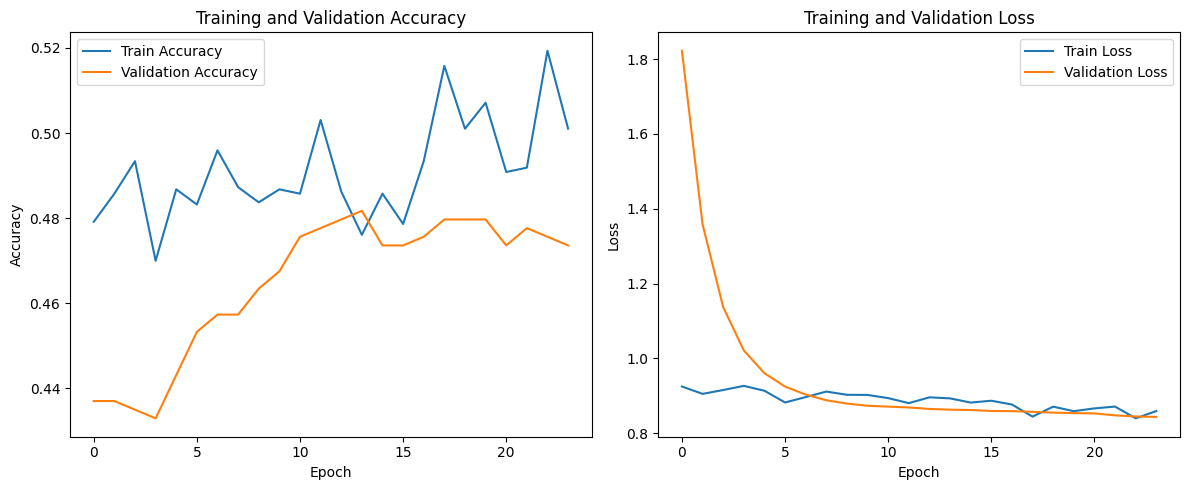

In [ ]:
plot_training_history_vgg(history_vgg16)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


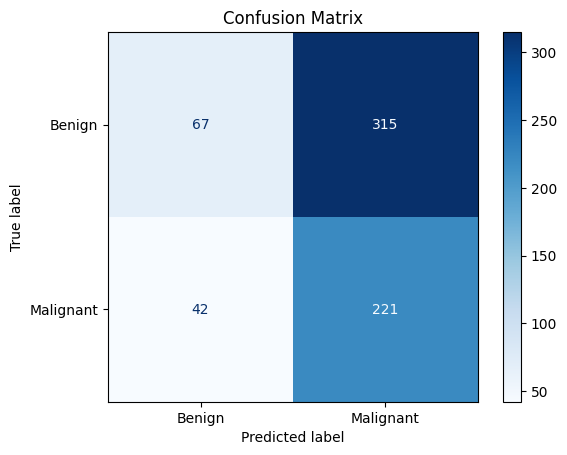

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
# Freeze all layers except the last 12
for layer in vgg16.layers[-12:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg16_12 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.4991 - loss: 0.8743 - precision: 0.4592 - recall: 0.6995 - val_accuracy: 0.4878 - val_loss: 1.0339 - val_precision: 0.4593 - val_recall: 0.9721 - learning_rate: 1.0000e-05
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5429 - loss: 0.8077 - precision: 0.4970 - recall: 0.6454 - val_accuracy: 0.4614 - val_loss: 1.1162 - val_precision: 0.4466 - val_recall: 0.9721 - learning_rate: 1.0000e-05
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.5481 - loss: 0.7749 - precision: 0.4946 - recall: 0.6539 - val_accuracy: 0.5711 - val_loss: 0.7402 - val_precision: 0.5063 - val_recall: 0.7535 - learning_rate: 1.0000e-05
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5754 - loss: 0.7323 - precision: 0.5144 - recall: 0.6622 - val_accuracy: 0.5000 - val_loss: 0.7688 - val_precision: 0.4587 - val_recall: 0.8000 - learning_rate: 1.0000e-05
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step

In [ ]:
def plot_training_history_vgg(history_vgg16_12):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg16_12.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg16_12.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg16_12.history['loss'], label='Train Loss')
    plt.plot(history_vgg16_12.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

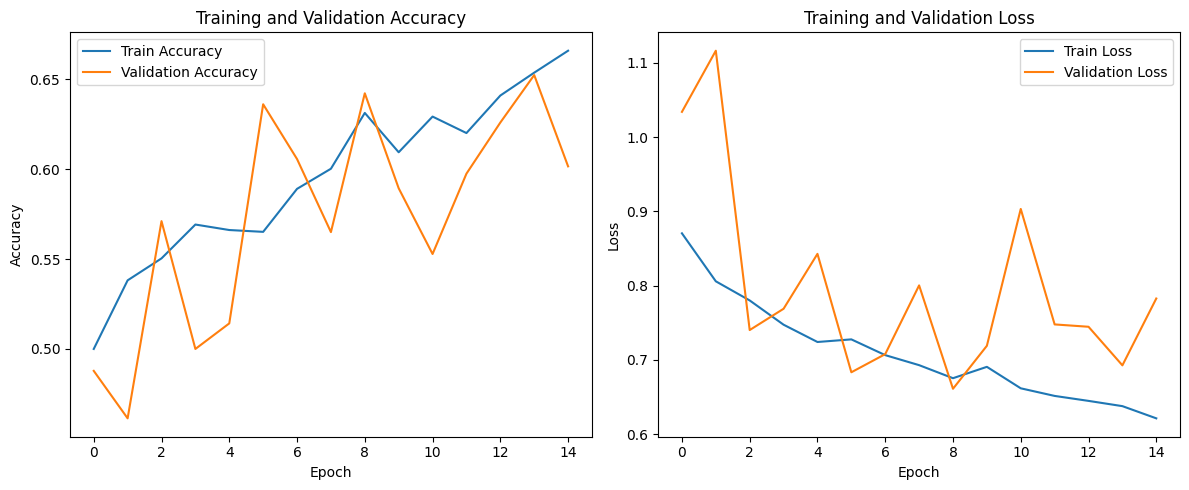

In [ ]:
plot_training_history_vgg(history_vgg16_12)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()4

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


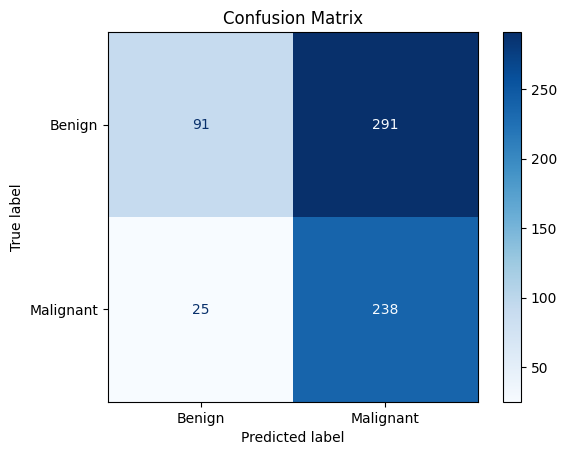

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,726,533 (166.80 MB)

 Trainable params: 14,488,449 (55.27 MB)

 Non-trainable params: 261,184 (1020.25 KB)

 Optimizer params: 28,976,900 (110.54 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4961 - loss: 1.0612 - precision: 0.4290 - recall: 0.9013


In [ ]:
# Freeze all layers except the last 10
for layer in vgg16.layers[-10:]:
    layer.trainable = True


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg16_10 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.6545 - loss: 0.6260 - precision: 0.6223 - recall: 0.6704 - val_accuracy: 0.6362 - val_loss: 0.7844 - val_precision: 0.5584 - val_recall: 0.8000 - learning_rate: 1.0000e-05
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.6627 - loss: 0.6148 - precision: 0.5962 - recall: 0.6703 - val_accuracy: 0.6545 - val_loss: 0.6695 - val_precision: 0.5983 - val_recall: 0.6372 - learning_rate: 1.0000e-05
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6595 - loss: 0.6037 - precision: 0.6079 - recall: 0.6931 - val_accuracy: 0.6423 - val_loss: 0.6404 - val_precision: 0.5961 - val_recall: 0.5628 - learning_rate: 1.0000e-05
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6652 - loss: 0.6182 - precision: 0.6042 - recall: 0.7066 - val_accuracy: 0.6321 - val_loss: 0.6972 - val_precision: 0.5594 - val_recall: 0.7442 - learning_rate: 1.0000e-05
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step 

In [ ]:
def plot_training_history_vgg(history_vgg16_10):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg16_10.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg16_10.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg16_10.history['loss'], label='Train Loss')
    plt.plot(history_vgg16_10.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

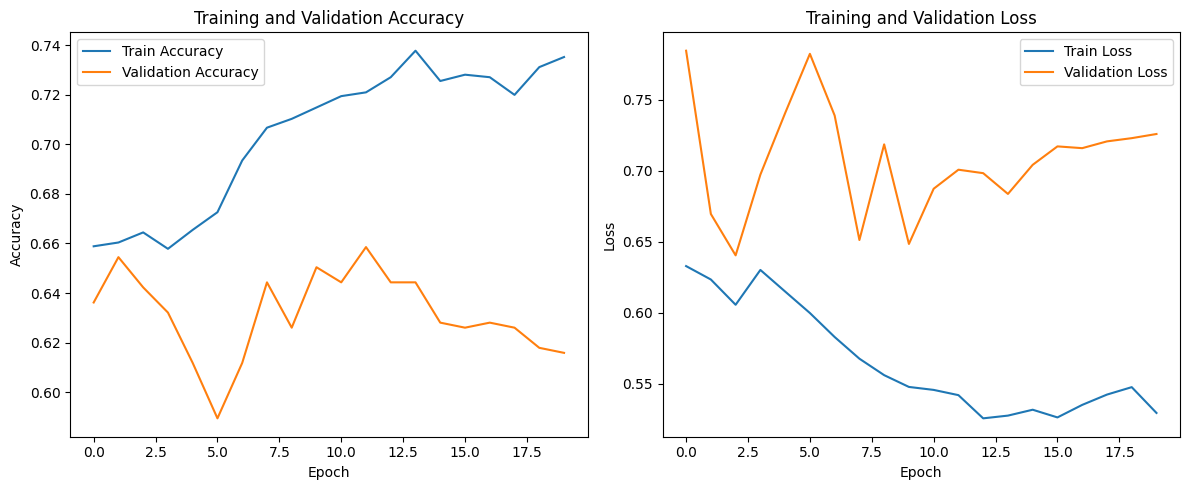

In [ ]:
plot_training_history_vgg(history_vgg16_10)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


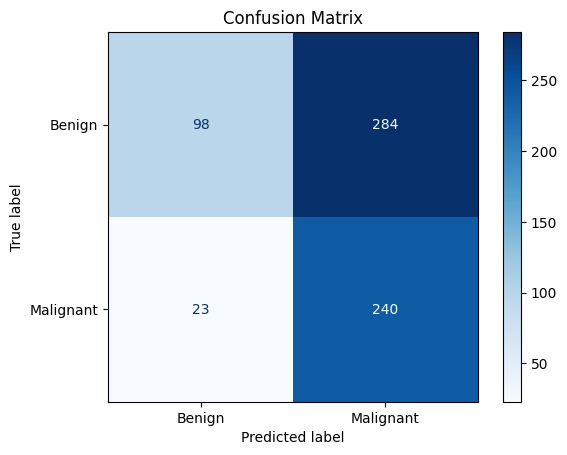

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,726,533 (166.80 MB)

 Trainable params: 14,488,449 (55.27 MB)

 Non-trainable params: 261,184 (1020.25 KB)

 Optimizer params: 28,976,900 (110.54 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4952 - loss: 1.0564 - precision: 0.4272 - recall: 0.8827


In [ ]:
# Freeze all layers except the last 8
for layer in vgg16.layers[-8:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg16_8 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.7130 - loss: 0.5470 - precision: 0.6584 - recall: 0.7420 - val_accuracy: 0.6301 - val_loss: 0.6857 - val_precision: 0.5613 - val_recall: 0.7023 - learning_rate: 1.0000e-05
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6991 - loss: 0.5674 - precision: 0.6480 - recall: 0.7258 - val_accuracy: 0.5833 - val_loss: 0.8136 - val_precision: 0.5140 - val_recall: 0.8558 - learning_rate: 1.0000e-05
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7239 - loss: 0.5104 - precision: 0.6728 - recall: 0.7416 - val_accuracy: 0.5569 - val_loss: 0.9831 - val_precision: 0.4963 - val_recall: 0.9442 - learning_rate: 1.0000e-05
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7148 - loss: 0.5480 - precision: 0.6686 - recall: 0.7239
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7152 - loss: 0.5477 - precision: 0.6

In [ ]:
def plot_training_history_vgg(history_vgg16_8):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg16_8.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg16_8.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg16_8.history['loss'], label='Train Loss')
    plt.plot(history_vgg16_8.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

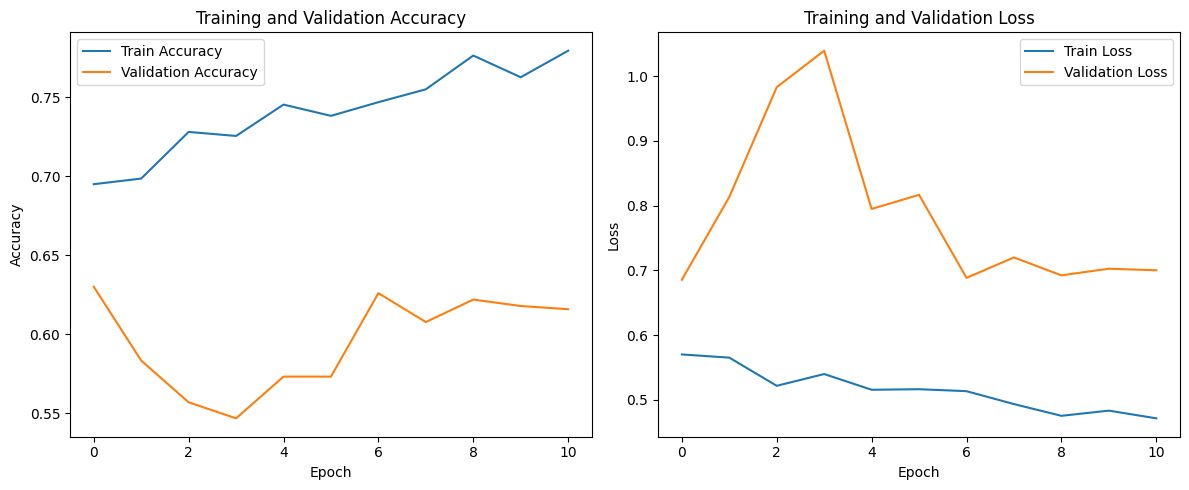

In [ ]:
plot_training_history_vgg(history_vgg16_8)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


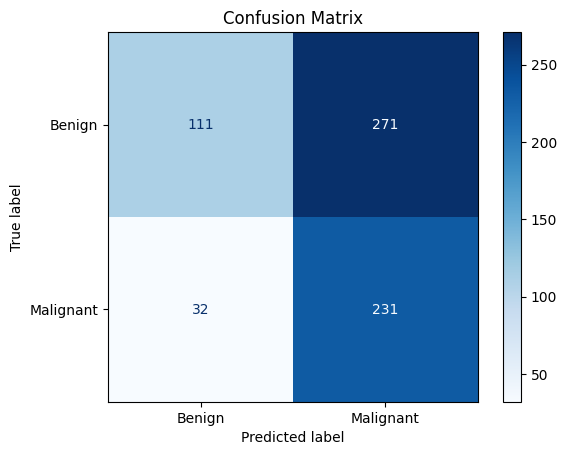

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,726,533 (166.80 MB)

 Trainable params: 14,488,449 (55.27 MB)

 Non-trainable params: 261,184 (1020.25 KB)

 Optimizer params: 28,976,900 (110.54 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5171 - loss: 1.0302 - precision: 0.4388 - recall: 0.8743


In [ ]:
# Freeze all layers except the last 6
for layer in vgg16.layers[-6:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg16_6 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.7243 - loss: 0.5520 - precision: 0.6924 - recall: 0.7223 - val_accuracy: 0.5488 - val_loss: 0.8004 - val_precision: 0.4912 - val_recall: 0.9116 - learning_rate: 1.0000e-05
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7184 - loss: 0.5592 - precision: 0.6857 - recall: 0.7123 - val_accuracy: 0.5325 - val_loss: 1.0999 - val_precision: 0.4824 - val_recall: 0.9581 - learning_rate: 1.0000e-05
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7211 - loss: 0.5397 - precision: 0.6773 - recall: 0.7433 - val_accuracy: 0.6402 - val_loss: 0.6936 - val_precision: 0.5660 - val_recall: 0.7581 - learning_rate: 1.0000e-05
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.7286 - loss: 0.5341 - precision: 0.6804 - recall: 0.7370 - val_accuracy: 0.6484 - val_loss: 0.6984 - val_precision: 0.5905 - val_recall: 0.6372 - learning_rate: 1.0000e-05
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step 

In [ ]:
def plot_training_history_vgg(history_vgg16_6):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg16_6.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg16_6.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg16_6.history['loss'], label='Train Loss')
    plt.plot(history_vgg16_6.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

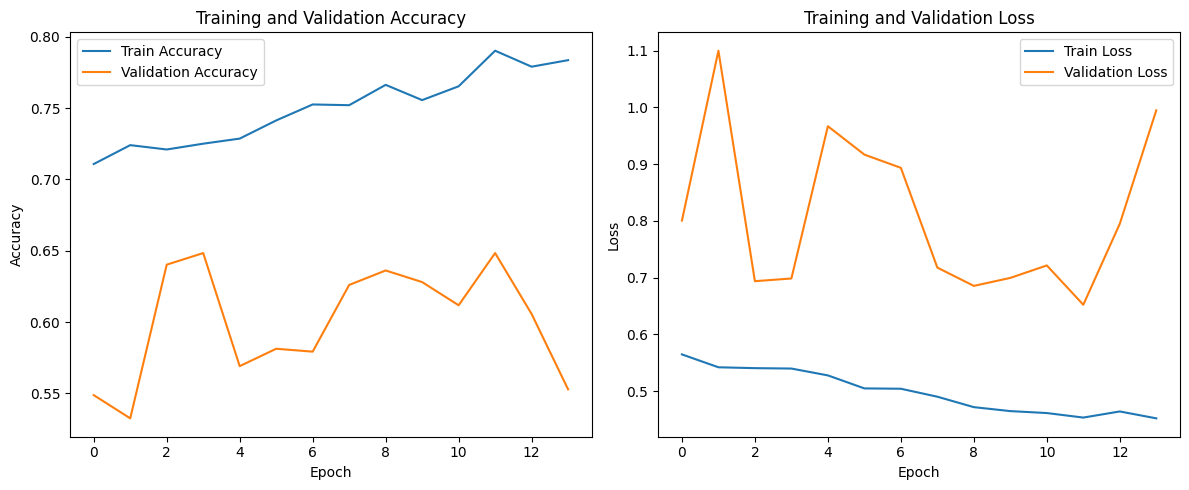

In [ ]:
plot_training_history_vgg(history_vgg16_6)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


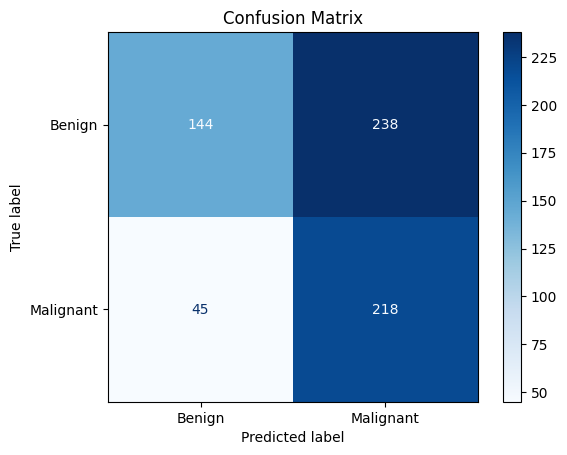

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,726,533 (166.80 MB)

 Trainable params: 14,488,449 (55.27 MB)

 Non-trainable params: 261,184 (1020.25 KB)

 Optimizer params: 28,976,900 (110.54 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5591 - loss: 0.9532 - precision: 0.4622 - recall: 0.8326


In [ ]:
# Freeze all layers except the last 4
for layer in vgg16.layers[-4:]:
    layer.trainable = True


In [ ]:
# Recompile with lower LR
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg16_4 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.7366 - loss: 0.5312 - precision: 0.6946 - recall: 0.7323 - val_accuracy: 0.6382 - val_loss: 0.7464 - val_precision: 0.5566 - val_recall: 0.8465 - learning_rate: 1.0000e-05
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7638 - loss: 0.4999 - precision: 0.7379 - recall: 0.7620 - val_accuracy: 0.5711 - val_loss: 0.9015 - val_precision: 0.5052 - val_recall: 0.9023 - learning_rate: 1.0000e-05
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7356 - loss: 0.5289 - precision: 0.6817 - recall: 0.7511 - val_accuracy: 0.5711 - val_loss: 0.8453 - val_precision: 0.5055 - val_recall: 0.8605 - learning_rate: 1.0000e-05
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7692 - loss: 0.4872 - precision: 0.7251 - recall: 0.7744 - val_accuracy: 0.6159 - val_loss: 0.6798 - val_precision: 0.5468 - val_recall: 0.7070 - learning_rate: 1.0000e-05
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step 

In [ ]:
def plot_training_history_vgg(history_vgg16_4):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg16_4.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg16_4.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg16_4.history['loss'], label='Train Loss')
    plt.plot(history_vgg16_4.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

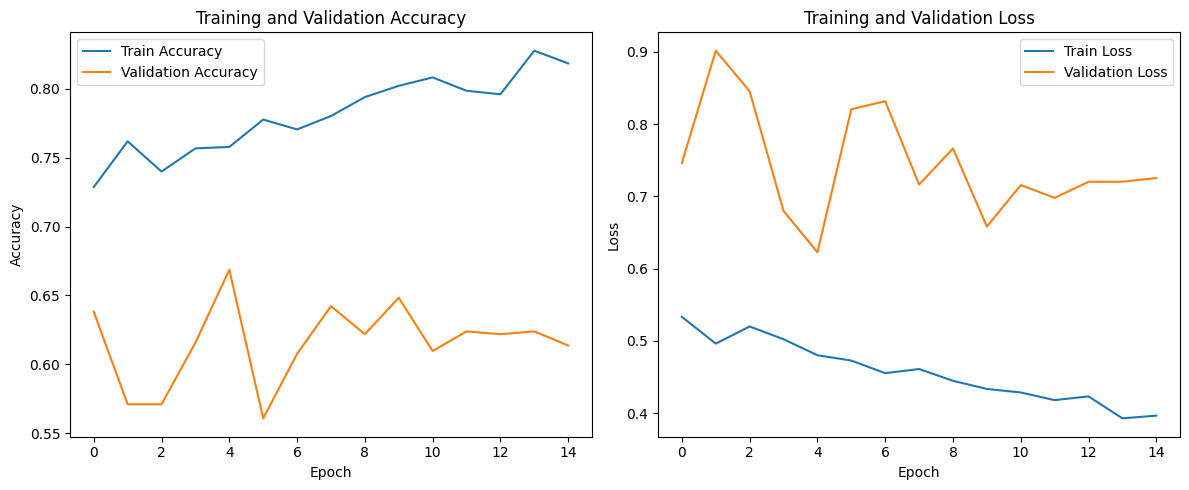

In [ ]:
plot_training_history_vgg(history_vgg16_4)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


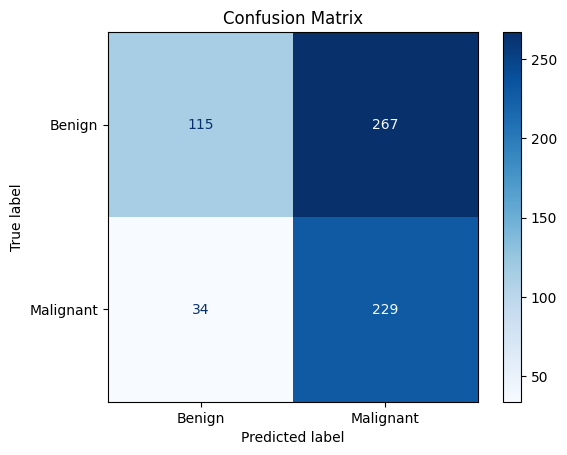

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,726,533 (166.80 MB)

 Trainable params: 14,488,449 (55.27 MB)

 Non-trainable params: 261,184 (1020.25 KB)

 Optimizer params: 28,976,900 (110.54 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5166 - loss: 0.8415 - precision: 0.4379 - recall: 0.8632


In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in vgg19.layers:
    layer.trainable = False

inputs = Input((224,224,3))
x = data_augmentation(inputs)
#denormlize pixels
x = layers.Lambda(lambda t: t * 255.0)(x)
x = layers.Lambda(preprocess_input)(x)
x = vgg19(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg19 = model.fit(
    X_train,  y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop,reduce_lr]
)


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.5078 - loss: 1.0479 - precision: 0.4602 - recall: 0.5771 - val_accuracy: 0.4350 - val_loss: 1.5997 - val_precision: 0.4356 - val_recall: 0.9907 - learning_rate: 1.0000e-05
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4796 - loss: 1.1307 - precision: 0.4468 - recall: 0.5503 - val_accuracy: 0.4370 - val_loss: 1.1931 - val_precision: 0.4351 - val_recall: 0.9674 - learning_rate: 1.0000e-05
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4878 - loss: 1.0879 - precision: 0.4487 - recall: 0.5302 - val_accuracy: 0.4593 - val_loss: 1.0042 - val_precision: 0.4430 - val_recall: 0.9209 - learning_rate: 1.0000e-05
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.4880 - loss: 1.0641 - precision: 0.4193 - recall: 0.5661 - val_accuracy: 0.4715 - val_loss: 0.9082 - val_precision: 0.4444 - val_recall: 0.8372 - learning_rate: 1.0000e-05
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step -

In [ ]:
#plotting accurcy and loss function
def plot_training_history_vgg(history_vgg19):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg19.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg19.history['loss'], label='Train Loss')
    plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

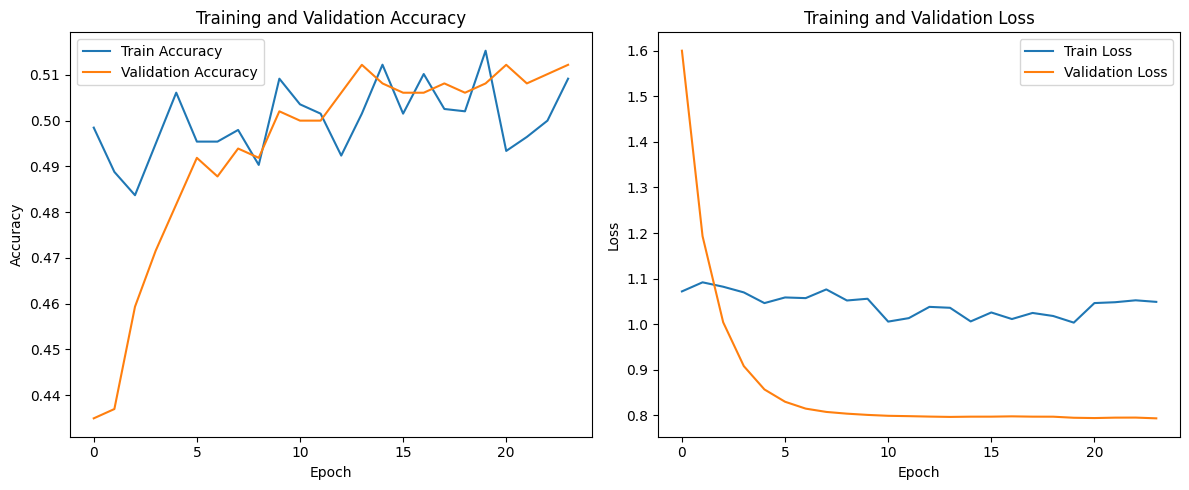

In [ ]:
plot_training_history_vgg(history_vgg19)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


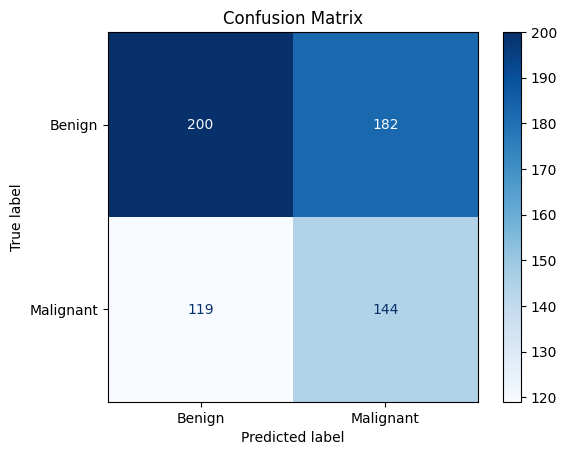

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,127,173 (76.78 MB)

 Trainable params: 33,921 (132.50 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

 Optimizer params: 67,844 (265.02 KB)

In [ ]:
# Freeze all layers except the last 12
for layer in vgg19.layers[-12:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg19_12 = model.fit(
    X_train,  y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.4997 - loss: 1.0604 - precision: 0.4493 - recall: 0.5483 - val_accuracy: 0.5772 - val_loss: 0.7441 - val_precision: 0.5205 - val_recall: 0.4140 - learning_rate: 1.0000e-05
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.4944 - loss: 1.0029 - precision: 0.4425 - recall: 0.5356 - val_accuracy: 0.5732 - val_loss: 0.7285 - val_precision: 0.5194 - val_recall: 0.3116 - learning_rate: 1.0000e-05
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.5238 - loss: 0.9631 - precision: 0.4789 - recall: 0.5758 - val_accuracy: 0.5915 - val_loss: 0.6931 - val_precision: 0.5376 - val_recall: 0.4651 - learning_rate: 1.0000e-05
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5128 - loss: 0.9416 - precision: 0.4755 - recall: 0.5610 - val_accuracy: 0.5894 - val_loss: 0.7716 - val_precision: 0.6444 - val_recall: 0.1349 - learning_rate: 1.0000e-05
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step 

In [ ]:
def plot_training_history_vgg(history_vgg19_12):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg19_12.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg19_12.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg19_12.history['loss'], label='Train Loss')
    plt.plot(history_vgg19_12.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

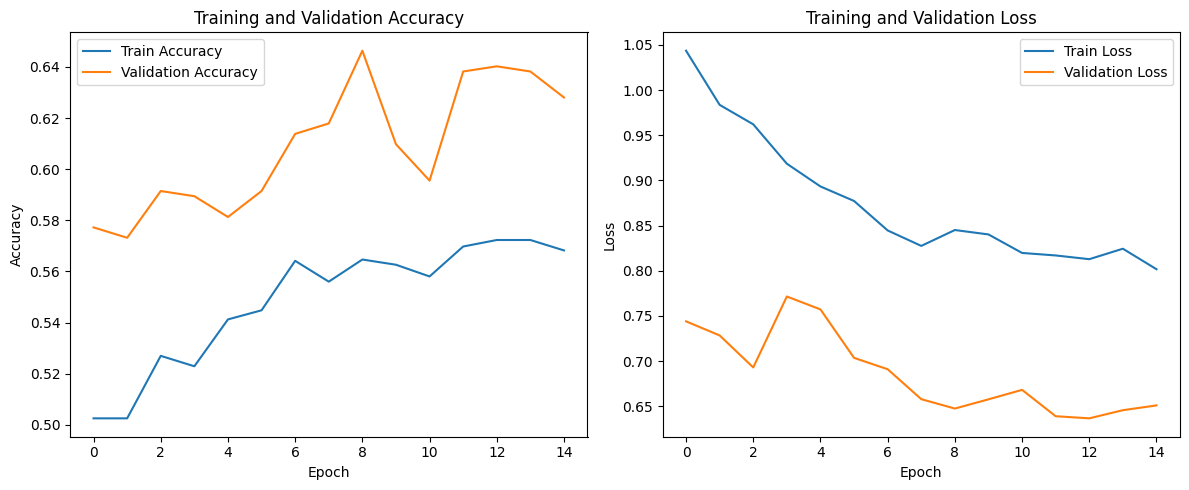

In [ ]:
plot_training_history_vgg(history_vgg19_12)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


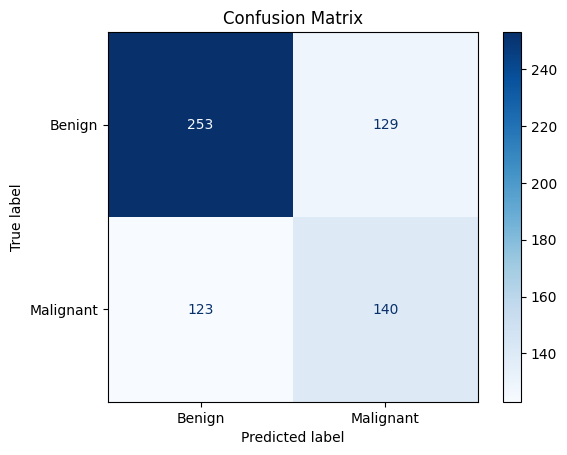

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,704,965 (216.31 MB)

 Trainable params: 18,322,817 (69.90 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

 Optimizer params: 36,645,636 (139.79 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6133 - loss: 0.6603 - precision: 0.5012 - recall: 0.5051


In [ ]:
# Freeze all layers except the last 10
for layer in vgg16.layers[-10:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg16_10 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.7254 - loss: 0.5453 - precision: 0.6895 - recall: 0.7177 - val_accuracy: 0.6687 - val_loss: 0.6208 - val_precision: 0.6757 - val_recall: 0.4651 - learning_rate: 1.0000e-05
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7030 - loss: 0.5755 - precision: 0.6496 - recall: 0.7047 - val_accuracy: 0.6667 - val_loss: 0.6313 - val_precision: 0.6123 - val_recall: 0.6465 - learning_rate: 1.0000e-05
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.7092 - loss: 0.5519 - precision: 0.6721 - recall: 0.7055 - val_accuracy: 0.6138 - val_loss: 0.7535 - val_precision: 0.5362 - val_recall: 0.8605 - learning_rate: 1.0000e-05
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7069 - loss: 0.5677 - precision: 0.6620 - recall: 0.7074
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.7064 - loss: 0.5679 - precision: 0.6

In [ ]:
def plot_training_history_vgg(history_vgg16_10):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg16_10.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg16_10.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg16_10.history['loss'], label='Train Loss')
    plt.plot(history_vgg16_10.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

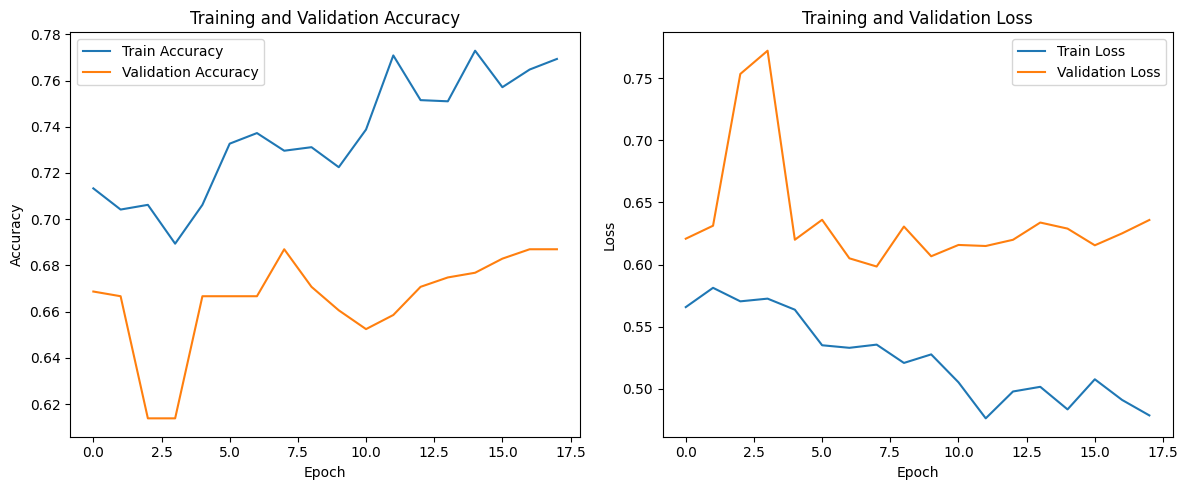

In [ ]:
plot_training_history_vgg(history_vgg16_10)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


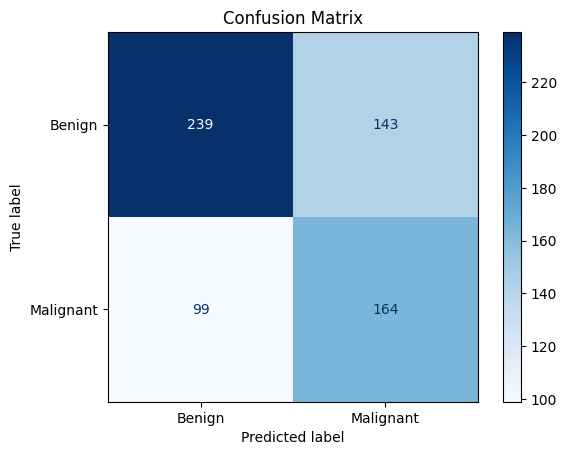

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,704,965 (216.31 MB)

 Trainable params: 18,322,817 (69.90 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

 Optimizer params: 36,645,636 (139.79 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5842 - loss: 0.7482 - precision: 0.4756 - recall: 0.7075


In [ ]:
# Freeze all layers except the last 8
for layer in vgg19.layers[-8:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg19_8 = model.fit(
    X_train,  y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.5972 - loss: 0.7415 - precision: 0.5556 - recall: 0.5908 - val_accuracy: 0.6199 - val_loss: 0.6350 - val_precision: 0.5795 - val_recall: 0.4744 - learning_rate: 1.0000e-05
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6097 - loss: 0.7093 - precision: 0.5500 - recall: 0.6436 - val_accuracy: 0.6220 - val_loss: 0.6194 - val_precision: 0.5639 - val_recall: 0.5953 - learning_rate: 1.0000e-05
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.6178 - loss: 0.7198 - precision: 0.5844 - recall: 0.5975 - val_accuracy: 0.6260 - val_loss: 0.6496 - val_precision: 0.5508 - val_recall: 0.7814 - learning_rate: 1.0000e-05
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.6255 - loss: 0.6937 - precision: 0.5790 - recall: 0.6336 - val_accuracy: 0.5976 - val_loss: 0.7070 - val_precision: 0.5244 - val_recall: 0.8512 - learning_rate: 1.0000e-05
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step 

In [ ]:
def plot_training_history_vgg(history_vgg19_8):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg19_8.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg19_8.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg19_8.history['loss'], label='Train Loss')
    plt.plot(history_vgg19_8.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

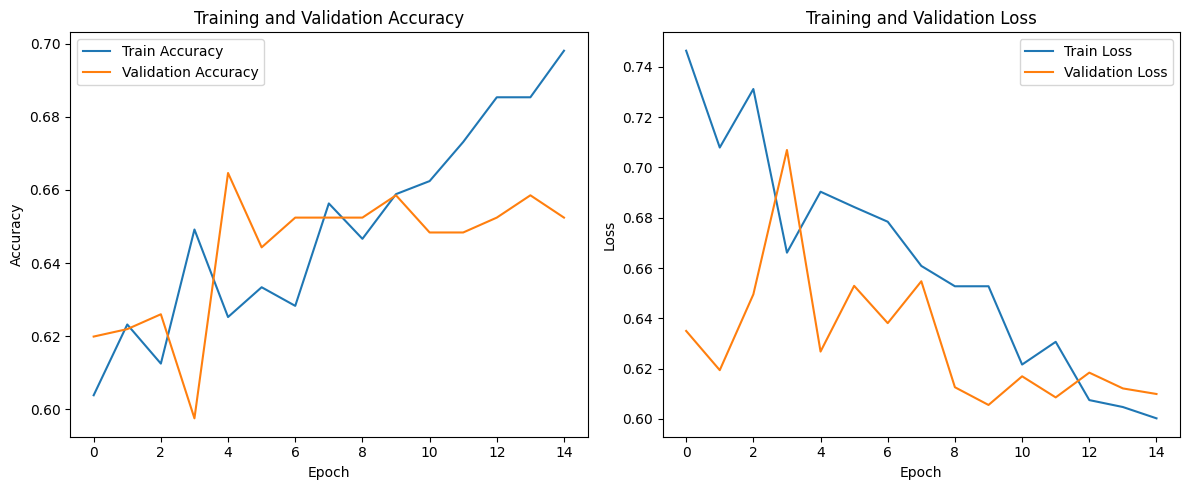

In [ ]:
plot_training_history_vgg(history_vgg19_8)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


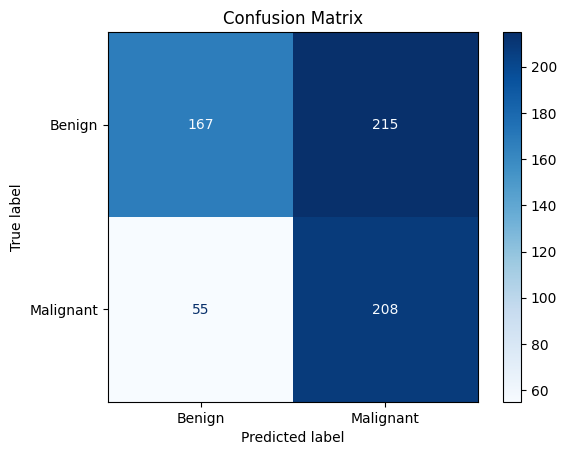

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,704,965 (216.31 MB)

 Trainable params: 18,322,817 (69.90 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

 Optimizer params: 36,645,636 (139.79 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5806 - loss: 0.7540 - precision: 0.4761 - recall: 0.8019


In [ ]:
# Freeze all layers except the last 6
for layer in vgg19.layers[-6:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg19_6 = model.fit(
    X_train,  y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.6388 - loss: 0.6812 - precision: 0.5927 - recall: 0.6324 - val_accuracy: 0.6646 - val_loss: 0.6081 - val_precision: 0.6087 - val_recall: 0.6512 - learning_rate: 1.0000e-05
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6344 - loss: 0.6715 - precision: 0.5954 - recall: 0.6343 - val_accuracy: 0.6423 - val_loss: 0.6367 - val_precision: 0.5694 - val_recall: 0.7442 - learning_rate: 1.0000e-05
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6387 - loss: 0.6787 - precision: 0.5847 - recall: 0.6660 - val_accuracy: 0.6321 - val_loss: 0.6730 - val_precision: 0.5521 - val_recall: 0.8372 - learning_rate: 1.0000e-05
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6332 - loss: 0.6733 - precision: 0.5851 - recall: 0.6267
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6331 - loss: 0.6733 - precision: 0.5

In [ ]:
def plot_training_history_vgg(history_vgg19_6):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg19_6.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg19_6.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg19_6.history['loss'], label='Train Loss')
    plt.plot(history_vgg19_6.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

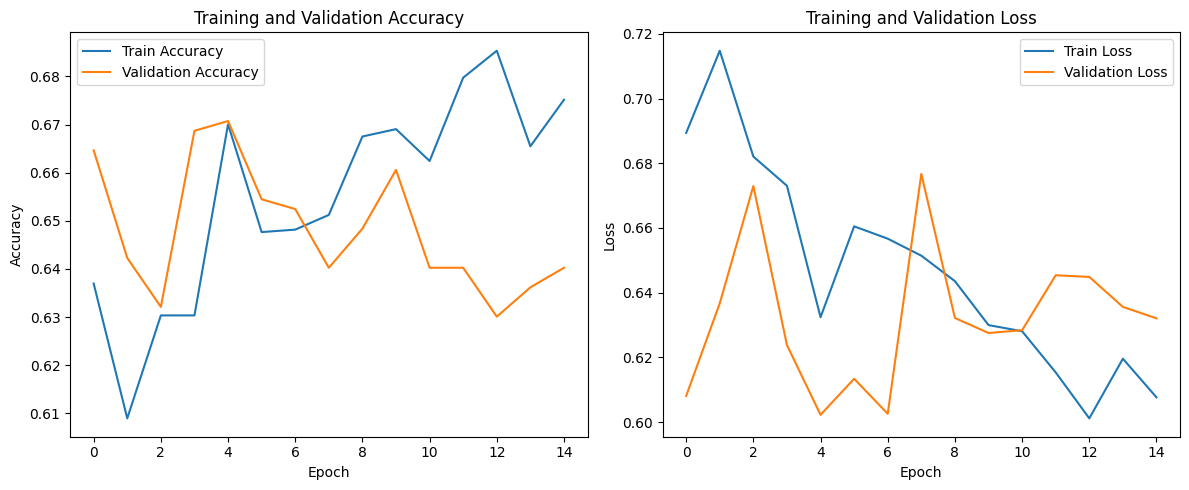

In [ ]:
plot_training_history_vgg(history_vgg19_6)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


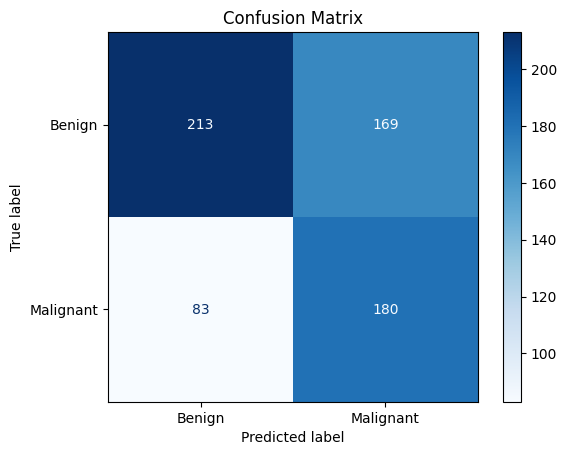

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,704,965 (216.31 MB)

 Trainable params: 18,322,817 (69.90 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

 Optimizer params: 36,645,636 (139.79 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5940 - loss: 0.7137 - precision: 0.4830 - recall: 0.6562


In [ ]:
# Freeze all layers except the last 4
for layer in vgg19.layers[-4:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

In [ ]:
history_vgg19_4 = model.fit(
    X_train,  y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.6215 - loss: 0.7035 - precision: 0.5668 - recall: 0.6147 - val_accuracy: 0.6626 - val_loss: 0.6119 - val_precision: 0.6017 - val_recall: 0.6744 - learning_rate: 1.0000e-05
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6643 - loss: 0.6417 - precision: 0.6325 - recall: 0.6521 - val_accuracy: 0.6423 - val_loss: 0.6294 - val_precision: 0.5759 - val_recall: 0.6884 - learning_rate: 1.0000e-05
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6553 - loss: 0.6308 - precision: 0.6149 - recall: 0.6573 - val_accuracy: 0.6016 - val_loss: 0.7690 - val_precision: 0.5262 - val_recall: 0.8884 - learning_rate: 1.0000e-05
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6764 - loss: 0.6025 - precision: 0.6351 - recall: 0.6650
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.6763 - loss: 0.6029 - precision: 0.6

In [ ]:
def plot_training_history_vgg(history_vgg19_4):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_vgg19_4.history['accuracy'], label='Train Accuracy')
    plt.plot(history_vgg19_4.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_vgg19_4.history['loss'], label='Train Loss')
    plt.plot(history_vgg19_4.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

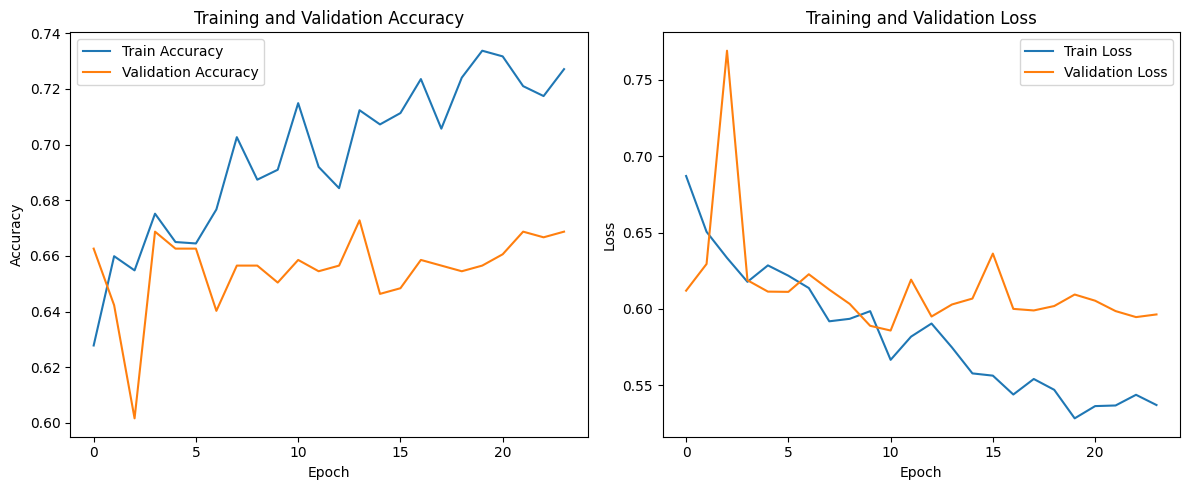

In [ ]:
plot_training_history_vgg(history_vgg19_4)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


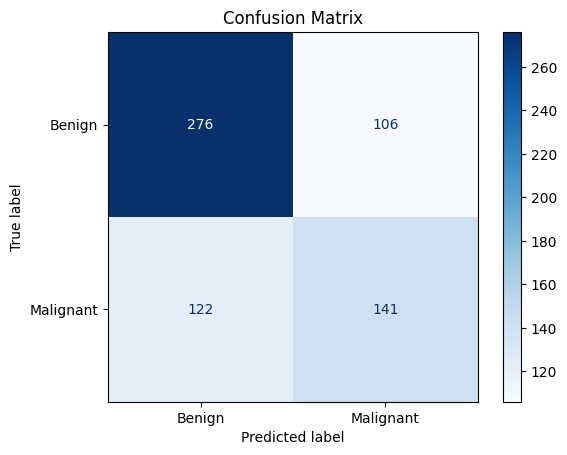

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,704,965 (216.31 MB)

 Trainable params: 18,322,817 (69.90 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

 Optimizer params: 36,645,636 (139.79 MB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6341 - loss: 0.6605 - precision: 0.5302 - recall: 0.5032


refrances
[1]
in Python, “Stack Overflow,” Stack Overflow, Aug. 10, 2010. Available: https://stackoverflow.com/questions/3451111/unzipping-files-in-python. [Accessed: Jun. 16, 2025]



[2]
GeeksforGeeks, “Python | os.path.join() method,” GeeksforGeeks, May 29, 2019. Available: https://www.geeksforgeeks.org/python/python-os-path-join-method/. [Accessed: Jun. 16, 2025]
‌

[3]
files, “Stack Overflow,” Stack Overflow, Jan. 16, 2018. Available: https://stackoverflow.com/questions/48290326/procesing-json-files-based-on-the-directory-name. [Accessed: Jun. 16, 2025]
‌



[4]
GeeksforGeeks, “cv2.imread() method Python OpenCV,” GeeksforGeeks, Aug. 02, 2019. Available: https://www.geeksforgeeks.org/python/python-opencv-cv2-imread-method/. [Accessed: Jun. 16, 2025]

[5]
GeeksforGeeks, “Image Resizing using OpenCV | Python,” GeeksforGeeks, Apr. 30, 2019. Available: https://www.geeksforgeeks.org/image-resizing-using-opencv-python/. [Accessed: Jun. 16, 2025]
‌


‌

[6]
GeeksforGeeks, “How to convert a grayscale image to RGB in OpenCV,” GeeksforGeeks, Jul. 23, 2024. Available: https://www.geeksforgeeks.org/computer-vision/how-to-convert-a-grayscale-image-to-rgb-in-opencv/. [Accessed: Aug. 01, 2025]
‌

[7]
K. class, “Stack Overflow,” Stack Overflow, Apr. 18, 2017. Available: https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding. [Accessed: Jun. 16, 2025]



[8]
Vladimir Lyashenko, “Data Augmentation in Python: Everything You Need to Know,” neptune.ai, Jul. 21, 2022. Available: https://neptune.ai/blog/data-augmentation-in-python. [Accessed: Jun. 16, 2025]
‌






‌

‌





[9]
Convolutional Neural Network (CNN, “Convolutional Neural Network (CNN),” TensorFlow, 2024. Available: https://www.tensorflow.org/tutorials/images/cnn. [Accessed: Jun. 16, 2025]
‌




[10]
A. Makarenko, “Boost Your Image Classification Model with pretrained VGG-16,” Medium, Mar. 26, 2023. Available: https://medium.com/geekculture/boost-your-image-classification-model-with-pretrained-vgg-16-ec185f763104. [Accessed: Aug. 01, 2025]
‌